# WMD

In [1]:
import mne
import json
import pylossless as ll
mne.viz.set_browser_backend('qt')

Using qt as 2D backend.


In [2]:
subject_raw = 'projects/wmd/sourcedata/wm_decision_000.bdf'
subject_deriv = 'projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_task-wmd_eeg.edf'

## Load Raw State

Necessary as events get purged during pipeline execution.

In [3]:
raw = mne.io.read_raw_bdf(subject_raw)
with open('projects/wmd/event_dict.json') as f:
    base_event_dict = json.loads(f.read())
row_events = [item for item in base_event_dict.keys() if item.startswith('stim')]
base_events = mne.find_events(raw, initial_event=True)
base_events

Extracting EDF parameters from /home/tyler/Documents/eeg-dev/projects/wmd/sourcedata/wm_decision_000.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
1457 events found
Event IDs: [    1     2     3     4    11    12    13    14    21    22    23    24
   100   101 65536]


array([[      0,       0,   65536],
       [   5944,       0,       3],
       [   6550,       0,      23],
       ...,
       [1278736,       0,       3],
       [1279368,       0,      23],
       [1279675,       0,     101]])

## Load Derivative Sate

In [4]:
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(subject_deriv)

eog_chans = ['M1', 'M2', 'LO1', 'LO2', 'IO1', 'IO2', 'Nose', 'EXG8']
ll_state.raw.set_montage('biosemi64', on_missing='ignore')
mapper = {item:'eog' for item in eog_chans}
ll_state.raw.set_channel_types(mapper)

for k,v in ll_state.flagged_chs.items():
    print(f'Merging "{k}" into bads with: ', v)
    ll_state.raw.info['bads'].extend(v)
print('Removing duplicates from bads...')
ll_state.raw.info['bads'] = list(set(ll_state.raw.info['bads']))
# ll_state.raw.info['bads'].remove('Status') # Sanity check
print('All bad channels: ', ll_state.raw.info['bads'])

# Load ICs marked as "bad" from pipeline output and apply
ll_state.ica2.exclude = list(ll_state.flagged_ics.data_frame.loc[ll_state.flagged_ics.data_frame['status'] == 'bad', 'component'])
ll_raw = ll_state.raw.copy()
ll_raw.load_data()
ll_state.ica2.apply(ll_raw)

ll_raw = ll_raw.filter(l_freq=1.0, h_freq=30.0)

ll_raw

Extracting EDF parameters from /home/tyler/Documents/eeg-dev/projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_task-wmd_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_task-wmd_events.tsv.
Reading channel info from projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_task-wmd_channels.tsv.
Reading electrode coords from projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_space-CapTrak_electrodes.tsv.
Reading projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_task-wmd_ica1_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading projects/wmd/derivatives/pylossless/sub-000/eeg/sub-000_task-wmd_ica2_ica.fif ...
Now restoring ICA solution ...
Ready.


/home/tyler/Documents/eeg-dev/pylossless/pylossless/pipeline.py:1216: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['M1', 'M2', 'LO1', 'LO2', 'IO1', 'IO2', 'Nose', 'EXG8']
  self.raw = mne_bids.read_raw_bids(derivatives_path)
/home/tyler/Documents/eeg-dev/pylossless/pylossless/pipeline.py:1216: RuntimeWarning: Not setting positions of 8 eog channels found in montage:
['M1', 'M2', 'LO1', 'LO2', 'IO1', 'IO2', 'Nose', 'EXG8']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  self.raw = mne_bids.read_raw_bids(derivatives_path)


Merging "manual" into bads with:  ['IO1' 'IO2' 'LO1' 'LO2' 'M1' 'M2' 'P2' 'P4']
Merging "ch_sd" into bads with:  ['M1' 'M2' 'LO1' 'LO2' 'IO1' 'IO2']
Merging "outliers" into bads with:  ['P4']
Merging "rank" into bads with:  ['P2']
Removing duplicates from bads...
All bad channels:  ['P4', 'LO1', 'M1', 'M2', 'IO1', 'P2', 'LO2', 'IO2']
Reading 0 ... 1332223  =      0.000 ...  2601.998 secs...
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 47 ICA components
    Projecting back using 62 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Uppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.7s finished


<RawEDF | sub-000_task-wmd_eeg.edf, 72 x 1332224 (2602.0 s), ~731.9 MB, data loaded>

In [5]:
# ll_raw.drop_channels(ll_raw.info['bads'])
# ll_raw = mne.preprocessing.compute_current_source_density(ll_raw)

In [6]:
metadata_tmin, metadata_tmax = -2.5, 0.1
row_events = ['response/correct', 'response/incorrect']
keep_last = ['stimulus', 'response']

metadata, events, event_id = mne.epochs.make_metadata(
    events=base_events, event_id=base_event_dict,
    tmin=metadata_tmin, tmax=metadata_tmax, sfreq=raw.info['sfreq'],
    row_events=row_events,
    keep_last=keep_last)
metadata

,event_name,stimulus/items/one,stimulus/items/two,stimulus/items/three,stimulus/items/four,stimulus/probe/congruent/one,stimulus/probe/congruent/two,stimulus/probe/congruent/three,stimulus/probe/congruent/four,stimulus/probe/incongruent/one,stimulus/probe/incongruent/two,stimulus/probe/incongruent/three,stimulus/probe/incongruent/four,response/incorrect,response/correct,boundary,stimulus,response,last_stimulus,last_response
19,response/correct,-1.716797,NaN,NaN,NaN,-0.400391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-0.400391,0.0,probe/congruent/one,correct
22,response/incorrect,-1.882812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.482422,NaN,NaN,NaN,0.0,NaN,NaN,-0.482422,0.0,probe/incongruent/one,incorrect
25,response/correct,-1.800781,NaN,NaN,NaN,-0.517578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-0.517578,0.0,probe/congruent/one,correct
28,response/correct,NaN,-1.851562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.634766,NaN,NaN,NaN,0.0,NaN,-0.634766,0.0,probe/incongruent/two,correct
31,response/correct,NaN,NaN,NaN,-1.882812,NaN,NaN,NaN,-0.599609,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-0.599609,0.0,probe/congruent/four,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,response/correct,-2.068359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.767578,NaN,NaN,NaN,NaN,0.0,NaN,-0.767578,0.0,probe/incongruent/one,correct
1447,response/correct,NaN,-1.968750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.583984,NaN,NaN,NaN,0.0,NaN,-0.583984,0.0,probe/incongruent/two,correct
1450,response/correct,NaN,NaN,-2.199219,NaN,NaN,NaN,-0.933594,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-0.933594,0.0,probe/congruent/three,correct
1453,response/correct,-1.751953,NaN,NaN,NaN,-0.435547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-0.435547,0.0,probe/congruent/one,correct


In [7]:
# epochs_tmin, epochs_tmax = -0.6, 0.4
# baseline = (-0.4, -0.2)

epochs_tmin, epochs_tmax = -2.2, 0.5
baseline = (-2.2, -0.38)

# Make sure the derivative is being chosen here
epochs = mne.Epochs(raw=ll_raw, tmin=epochs_tmin, tmax=epochs_tmax,
                    baseline=baseline,
                    events=events, event_id=event_id, metadata=metadata,
                    preload=True)
epochs = epochs['last_stimulus.notna()']

Adding metadata with 20 columns
480 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 480 events and 1383 original time points ...
55 bad epochs dropped


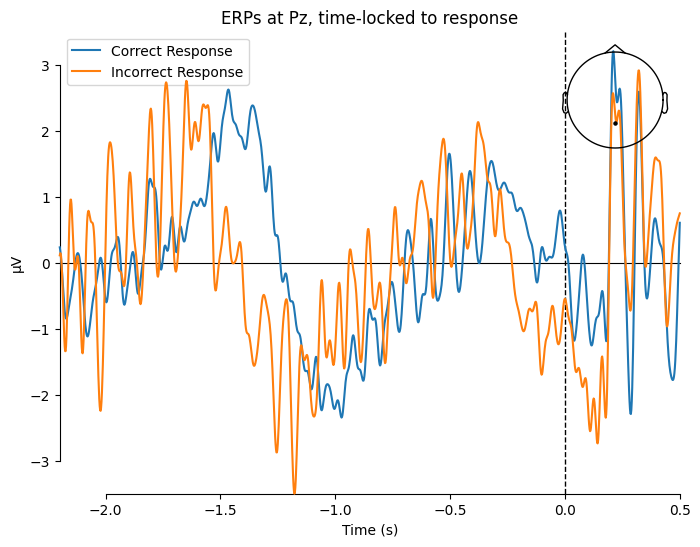

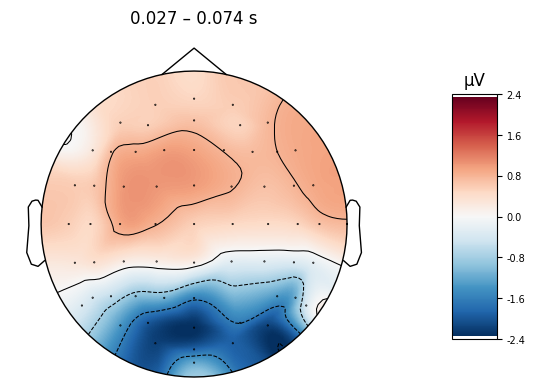

Text(0.5, 0.98, 'Avg. topography after incorrect responses')

In [8]:
resp_erp_correct = epochs['last_response == "correct"'].average()
resp_erp_incorrect = epochs['last_response == "incorrect"'].average()

mne.viz.plot_compare_evokeds({'Correct Response': resp_erp_correct,
                              'Incorrect Response': resp_erp_incorrect},
                             picks='Pz', show_sensors=True,
                             title='ERPs at Pz, time-locked to response')

# topoplot of average field from time 0.0-0.1 s
fig = resp_erp_incorrect.plot_topomap(times=0.05, average=0.05, size=3)
fig.suptitle('Avg. topography after incorrect responses', fontsize=16)

combining channels using "mean"


/tmp/ipykernel_93313/1502139117.py:4: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, picks='Pz', combine='mean')


combining channels using "mean"


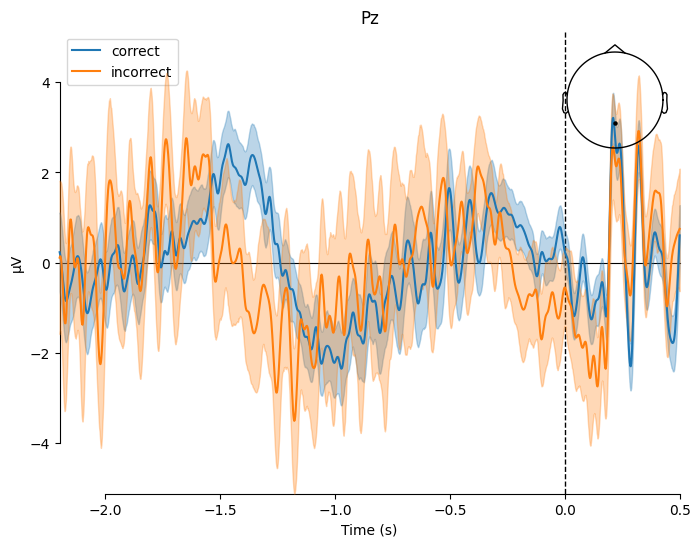

[<Figure size 800x600 with 2 Axes>]

In [9]:
evokeds = {'correct': list(epochs['last_response == "correct"'].iter_evoked()),
           'incorrect': list(epochs['last_response == "incorrect"'].iter_evoked())}

mne.viz.plot_compare_evokeds(evokeds, picks='Pz', combine='mean')